In [10]:
import obspy, glob
import numpy as np
from obspy import Trace, UTCDateTime
from scipy.io.wavfile import read, write
import matplotlib.pyplot as plt
# import h5py
import matplotlib.dates as mdates
from matplotlib import cm
from datetime import datetime, date, timedelta
from scipy import signal
import numpy.matlib
from scipy.signal import hilbert
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [11]:
def calib(data, S):
    audio_data = data.astype(np.float32, order='C') / 32768.0
    calib_data = audio_data / ((10)**(S/20))
    return calib_data # uPa

In [12]:
path = '/Volumes/Data/Soundscape/03_TaoYuan/2023/20230414-20230501TaoYuan/wav'

S = -176.1 # end to end 
P_ref = 1 # water: 1 uPa
interval = 1 # min

In [25]:
def SPL(tr):
    data = tr.data
    P_ref = 1
    dp = int(0.002*48000) # ms*rate 
    findpeak = [] 
    spl_p2p = []
    cont_score = []
    for tt in range(0, data.shape[0], dp):
        data_ = data[tt:tt+dp]
        # p_rms = np.sqrt(np.mean(data_**2))
        p_peak = max(data_)+abs(min(data_)) # Equ.22 #max(abs(data_))
        max_idx = np.where(data_ == max(data_))[0][0]
        P_spl = 10*np.log10(p_peak**2/P_ref**2)
        
        envelope = np.abs(hilbert(data_)) / max(np.abs(hilbert(data_)))
        k_data = smooth(envelope)
        score = detection(k_data, envelope)
        cont_score.append(score)
        
        if score >= 0.8 and P_spl >= 125:
            findpeak.append((tt+max_idx))
            spl_p2p.append(P_spl)
            # plt.figure(figsize=(3,4))
            # plt.subplot(211)

            # print(k_data)
            # plt.plot(np.linspace(0, 0.002, dp)*1000, k_data, 'b', lw=3)
            # plt.plot(np.linspace(0, 0.002, dp)*1000, envelope, 'r', lw=1)
            # plt.plot(np.linspace(0, 0.002, dp)*1000, data_ / max(abs(data_)), 'k', lw=1)
            # plt.xlim(0, 2)
            # plt.subplot(212)
            # f, t, spectro = spectrogram(data_)
            # plt.imshow(spectro, vmin=40, vmax=70,
            #            origin='lower',  aspect='auto', cmap=cm.jet,
            #            extent=[0, 2, f[0]/1000, f[-1]/1000], interpolation='none')
            # plt.ylabel('Frequency [kHz]')
            # plt.xlabel('Time [ms]')  
            # plt.suptitle(f'{round(P_spl,2), round(score,2)}')
            # print(tt, P_spl,score,)
            
                       
    return findpeak, cont_score, spl_p2p
        
            
            
def spectrogram(data, length=16):
    f,t,P = signal.stft(data, fs= 48000, window='hann', 
            nperseg=length, noverlap=int(0.9*length), detrend='constant', boundary=None, padded=False)
    data = 10*np.log10(np.abs(P)/np.power(1, 2))

    return f, t, data

def smooth(x ):
    # from scipy.ndimage.filters import gaussian_filter1d
    # filterdData = gaussian_filter1d(x,3)
    # from scipy.signal import savgol_filter
    # filterdData = savgol_filter(x, 20, 5, mode='nearest')
    from scipy.signal import medfilt
    filterdData = medfilt(x, kernel_size=9)
    return filterdData
def detection(kernel, envelope):
    
    nor_k = kernel / max(kernel)
    nor_e = envelope / max(envelope)
    np_score = np.corrcoef(nor_k, nor_e)
    score = np_score[0][1]
    return score

In [14]:
df_min = {'Time':[],
         'Peak': [],
         'MaxSPL': [], 
         'SPLrms':[]}
for file in glob.glob(f'{path}/*23041820*.wav'):
    print(file)
    rate, data_ = read(file) 
    data = calib(data_, S)
    
    filetime = file.rsplit('.')[1]
    tr = Trace()
    tr.data = data
    tr.stats.sampling_rate = rate
    if rate == 96000:
        tr.decimate(2, no_filter=True)
    
    tr.stats.starttime = UTCDateTime(2023, int(filetime[2:4]), int(filetime[4:6]), int(filetime[6:8]), int(filetime[8:10]), int(filetime[10:]))
    tr_bp = tr.copy()
    tr_bp.filter('highpass', freq=4000, corners=6, zerophase=True)
    
    total_min = int(tr.stats.endtime - tr.stats.starttime)/60
    

    for mm in range(int(total_min)):
        
        df_sec = {'Time':[],
                 'Peak': [],
                 'MaxSPL': []}
        
        tr_cut = tr_bp.copy()
        start = tr.stats.starttime + mm*60 
        end = start + 60
        tr_cut = tr_cut.slice(starttime=start, endtime=end)
        
        p_rms = np.sqrt(np.mean(tr_cut.data**2))
        P_spl = 20*np.log10(p_rms/P_ref)
        
        for ss in range(60):
            tr_cut = tr_bp.copy()
            start = tr.stats.starttime + mm*60 + ss
            end = start + 1 
            tr_cut = tr_cut.slice(starttime=start, endtime=end)

            findpeak, all_score, SPL_p2p = SPL(tr_cut)

            df_sec['Time'].append(tr_cut.stats.starttime)
            df_sec['Peak'].append(len(findpeak))
            df_sec['MaxSPL'].append(max(SPL_p2p))
            
        tr_time = tr_cut.stats.starttime
        df_min['Time'].append(UTCDateTime(tr_time.year, tr_time.month, tr_time.day, tr_time.hour, tr_time.minute))
        df_min['Peak'].append(sum(df_sec['Peak']))
        df_min['MaxSPL'].append(max(df_sec['MaxSPL']))
        df_min['SPLrms'].append(P_spl)
    
df_min = pd.DataFrame(df_min)
        

/Volumes/Data/Soundscape/03_TaoYuan/2023/20230414-20230501TaoYuan/wav/7081.230418200009.wav
/Volumes/Data/Soundscape/03_TaoYuan/2023/20230414-20230501TaoYuan/wav/7081.230418200509.wav
/Volumes/Data/Soundscape/03_TaoYuan/2023/20230414-20230501TaoYuan/wav/7081.230418201009.wav
/Volumes/Data/Soundscape/03_TaoYuan/2023/20230414-20230501TaoYuan/wav/7081.230418201509.wav
/Volumes/Data/Soundscape/03_TaoYuan/2023/20230414-20230501TaoYuan/wav/7081.230418202009.wav
/Volumes/Data/Soundscape/03_TaoYuan/2023/20230414-20230501TaoYuan/wav/7081.230418202509.wav
/Volumes/Data/Soundscape/03_TaoYuan/2023/20230414-20230501TaoYuan/wav/7081.230418203009.wav
/Volumes/Data/Soundscape/03_TaoYuan/2023/20230414-20230501TaoYuan/wav/7081.230418203509.wav
/Volumes/Data/Soundscape/03_TaoYuan/2023/20230414-20230501TaoYuan/wav/7081.230418204009.wav
/Volumes/Data/Soundscape/03_TaoYuan/2023/20230414-20230501TaoYuan/wav/7081.230418204509.wav
/Volumes/Data/Soundscape/03_TaoYuan/2023/20230414-20230501TaoYuan/wav/7081.23041

In [15]:
df_min

,Time,Peak,MaxSPL,SPLrms
0,2023-04-18T20:01:00.000000Z,3115,158.638829,116.613963
1,2023-04-18T20:02:00.000000Z,3193,166.253660,116.726534
2,2023-04-18T20:03:00.000000Z,3097,168.272873,117.402341
3,2023-04-18T20:04:00.000000Z,3042,172.354477,117.676806
4,2023-04-18T20:05:00.000000Z,3102,167.367549,117.084656
5,2023-04-18T20:06:00.000000Z,3083,168.398513,117.488056
6,2023-04-18T20:07:00.000000Z,3052,165.297481,116.765233
7,2023-04-18T20:08:00.000000Z,3073,171.301628,117.356621
8,2023-04-18T20:09:00.000000Z,3288,157.016935,116.043617
9,2023-04-18T20:10:00.000000Z,3027,161.590780,116.678557


## for plotting 

calculating spectrogram ......
find peak ........
plot peak ........
52


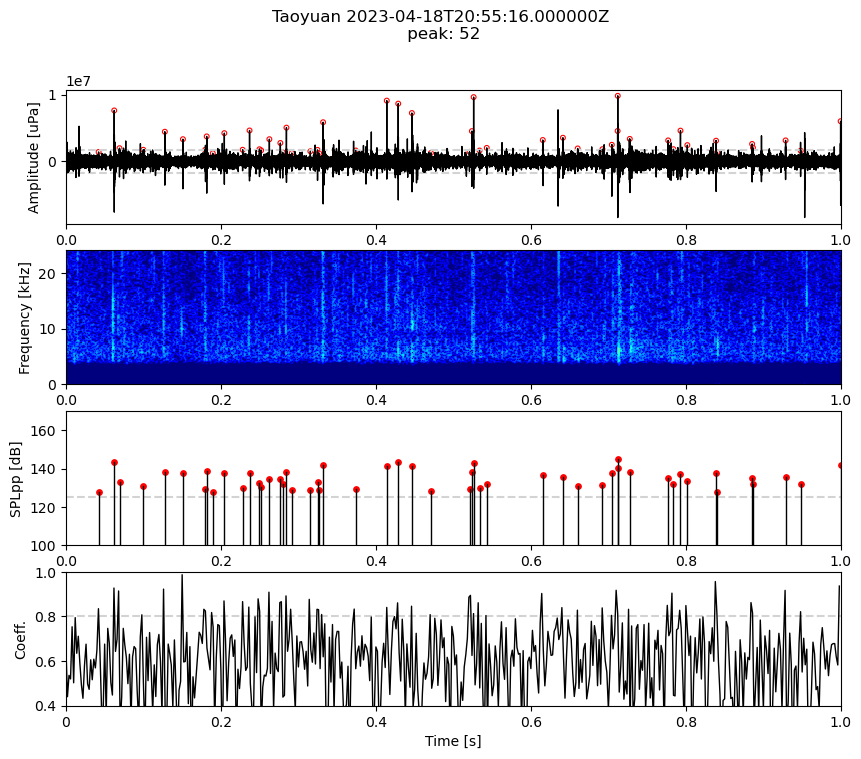

In [32]:
df = {'Time':[],
     'Peak': [],
     'MaxSPL': []}
plot = True
total_sec = int(tr_bp.stats.endtime - tr_bp.stats.starttime)
for dt in np.arange(7,8, interval):
    tr_cut = tr_bp.copy()
    start  = tr_bp.stats.starttime + dt
    end    = start+1
    tr_cut = tr_cut.slice(starttime=start, endtime=end)
    
    findpeak, all_score, SPL_p2p = SPL(tr_cut)
    
    df['Time'].append(tr_cut.stats.starttime)
    df['Peak'].append(len(findpeak))
    df['MaxSPL'].append(max(SPL_p2p))
    
    if plot:
        fig, ax = plt.subplots(4, 1, figsize=(10,8))
        ax[0].hlines(xmin=tr_cut.times()[0], xmax=tr_cut.times()[-1], y=1.778*10**6, color='lightgrey', ls='--')
        ax[0].hlines(xmin=tr_cut.times()[0], xmax=tr_cut.times()[-1], y=-1.778*10**6, color='lightgrey', ls='--')
        
        ax[0].plot(tr_cut.times(), tr_cut.data, 'k', lw=1)
        ax[0].set_xlim(tr_cut.times()[0], tr_cut.times()[-1])
        ax[0].set_ylabel('Amplitude [uPa]')

        f, t, data_1min = spectrogram(tr_cut.data, length=512/2)
        print('calculating spectrogram ......')
        ax[1].imshow(data_1min, vmin=40, vmax=80,
                               origin='lower',  aspect='auto', cmap=cm.jet,
                               extent=[0, 1, f[0]/1000, f[-1]/1000], interpolation='none')
        ax[1].set_ylabel('Frequency [kHz]')

        print('find peak ........')

        ax[2].hlines(xmin=tr_cut.times()[0], xmax=tr_cut.times()[-1], y=125, color='lightgrey', ls='--')
        ax[3].hlines(xmin=0, xmax=tr_cut.data.shape[0], y=0.8, color='lightgrey', ls='--')
        ax[3].plot(range(0,tr_cut.data.shape[0], int(0.002*48000)), all_score, c='k', linewidth=1)
        # ax[2].scatter(range(0,tr_cut.data.shape[0], int(0.002*48000)), all_score, marker = 'o', s= 10, color='black')
        ax[3].set_ylim(0.4,1)
        ax[3].set_xlim(0,tr_cut.data.shape[0])
        ax[3].set_xticks(ticks=range(0,tr_cut.data.shape[0], int(0.2*48000)), labels=[0, 0.2,0.4,0.6,0.8,1.0])
        ax[3].set_ylabel('Coeff.')
        ax[3].set_xlabel('Time [s]')
        # ax[2].set_xticks(range(0,tr_cut.data.shape[0], int(0.002*48000)), labels=)
        print('plot peak ........')

        for i, idx in enumerate(findpeak):
            corr_time = 0 + idx/48000
            corr_y = tr_cut.data[idx]
            ax[0].scatter(corr_time,corr_y, marker = 'o', s= 12, color='none', linewidths=0.8, edgecolor='red' )
            ax[2].plot([corr_time,corr_time], [100,SPL_p2p[i]], c='k', linewidth=1 )
            ax[2].scatter(corr_time,SPL_p2p[i], marker = 'o', s= 15, color='red', linewidths=1, edgecolor='red' )
        print(len(findpeak))
        ax[2].set_ylim(100, 170)
        ax[2].set_ylabel('SPLpp [dB]')
        ax[2].set_xlim(tr_cut.times()[0], tr_cut.times()[-1])

        plt.suptitle(f'Taoyuan {start}\n peak: {len(findpeak)}')

df = pd.DataFrame(df)
# df.to_csv()

In [33]:
52*60

3120

In [29]:
125/20

6.25

In [ ]:
 P_spl = 10*np.log10(p_peak**2/P_ref**2)